In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
inputs = tf.placeholder(tf.float32, [None,120,25,1], 'inputs')
targets = tf.placeholder(tf.float32, [None, 25], 'targets')

/afs/inf.ed.ac.uk/user/s17/s1773005/miniconda3/envs/mlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_error_and_accuracy(data):
    """Calculate average error and classification accuracy across a dataset.
    
    Args:
        data: Data provider which iterates over input-target batches in dataset.
        
    Returns:
        Tuple with first element scalar value corresponding to average error
        across all batches in dataset and second value corresponding to
        average classification accuracy across all batches in dataset.
    """
    err = 0
    acc = 0
    for input_batch, target_batch in data:
        err += sess.run(error, feed_dict={inputs: input_batch, targets: target_batch})
        acc += sess.run(accuracy, feed_dict={inputs: input_batch, targets: target_batch})
    err /= data.num_batches
    acc /= data.num_batches
    return err, acc

In [3]:
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides = [1, 1, 1, 1], padding = 'VALID')
def pool(x, m, n):
    """
    
    Args:
        x: outputs of the last layer
        m: Raw of the max_pooling
        n: Column of the max_pooling
    
    """
    return tf.nn.max_pool(x, ksize = [1, m, n, 1], strides = [1, m, n, 1], padding = 'VALID')

In [4]:
weights = {
    'c1': tf.Variable(tf.random_normal([5, 5, 1, 5])),
    'c2': tf.Variable(tf.random_normal([5, 5, 5, 10])),
    'out': tf.Variable(tf.random_normal([5*1*10, 25]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([5])),
    'b2': tf.Variable(tf.random_normal([10])),
    'out': tf.Variable(tf.random_normal([25]))
}

def multilayer_cnn(data):
    conv1 = tf.nn.tanh(conv2d(data, weights['c1']) + biases['b1'])
    pool1 = pool(conv1, 4, 3)
    conv2 = tf.nn.tanh(conv2d(pool1, weights['c2']) + biases['b2'])
    pool2 = pool(conv2, 5, 3)
    pool2_flat = tf.reshape(pool2, [-1, 5*1*10])
    out_layer = tf.matmul(pool2_flat, weights['out']) + biases['out']
    return out_layer
out_layer = multilayer_cnn(inputs)

per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=targets)
error = tf.reduce_mean(per_datapoint_errors)
#regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2'])+tf.nn.l2_loss(weights['out'])
#error = tf.reduce_mean(error + beta * regularizer)

per_datapoint_pred_is_correct = tf.equal(tf.argmax(out_layer, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()
sess.run(init_op)
import data_providers_cnn as data_providers_cnn
train_data = data_providers_cnn.MSD25GenreDataProvider('train', batch_size=50, flatten=True, one_hot=True)
valid_data = data_providers_cnn.MSD25GenreDataProvider('valid', batch_size=50, flatten=True, one_hot=True)

num_epoch = 50
error_train = []
error_valid = []
acc_train = []
acc_valid = []

for e in range(num_epoch):
    running_error = 0.
    running_acc = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_acc += batch_acc
    running_error /= train_data.num_batches
    running_acc /= train_data.num_batches
    print('End of epoch {0}: running error average = {1:.2f}'.format(e + 1, running_error), 
          'running acc average = {1:.2f}'.format(e + 1, running_acc))
    error_train = np.append(error_train, running_error)
    acc_train = np.append(acc_train, running_acc)
    a = get_error_and_accuracy(valid_data)
    error_valid = np.append(error_valid, a[0])
    acc_valid = np.append(acc_valid, a[1])
    
CNN_2layers_25 = [error_train, acc_train, error_valid, acc_valid]
np.save('CNN_2layers_25', CNN_2layers_25)

End of epoch 1: running error average = 3.88 running acc average = 0.12
End of epoch 2: running error average = 2.29 running acc average = 0.14
End of epoch 3: running error average = 2.28 running acc average = 0.15
End of epoch 4: running error average = 2.27 running acc average = 0.15
End of epoch 5: running error average = 2.26 running acc average = 0.16
End of epoch 6: running error average = 2.25 running acc average = 0.16
End of epoch 7: running error average = 2.20 running acc average = 0.18
End of epoch 8: running error average = 2.15 running acc average = 0.19
End of epoch 9: running error average = 2.13 running acc average = 0.19
End of epoch 10: running error average = 2.10 running acc average = 0.20
End of epoch 11: running error average = 2.09 running acc average = 0.21
End of epoch 12: running error average = 2.08 running acc average = 0.21
End of epoch 13: running error average = 2.06 running acc average = 0.22
End of epoch 14: running error average = 2.05 running acc av

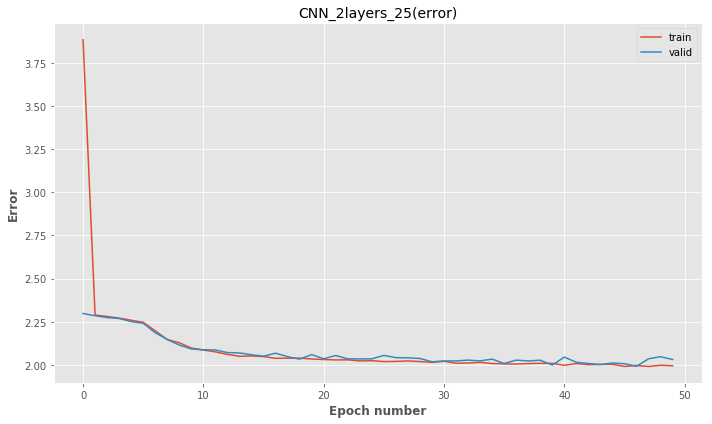

In [5]:
data = np.load('CNN_2layers_25.npy')

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[0].shape[0]), data[0], label = 'train')
ax_1.plot(np.arange(data[2].shape[0]), data[2], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('Error', fontsize = 12, fontweight = 1000)
ax_1.set_title('CNN_2layers_25(error)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('CNN_2layers_25(error).pdf')

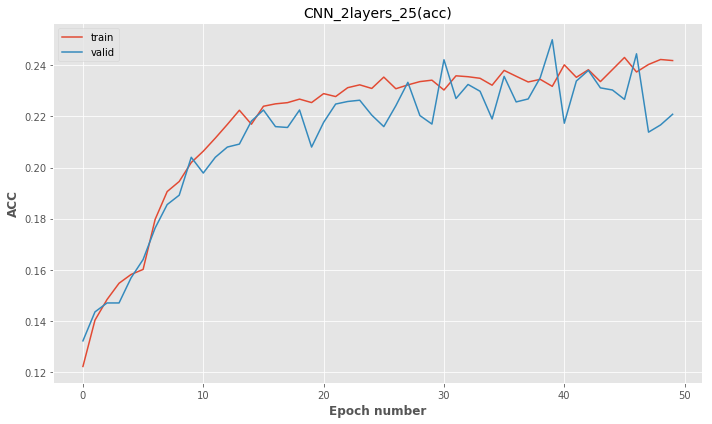

In [6]:
data = np.load('CNN_2layers_25.npy')

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[1].shape[0]), data[1], label = 'train')
ax_1.plot(np.arange(data[3].shape[0]), data[3], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('ACC', fontsize = 12, fontweight = 1000)
ax_1.set_title('CNN_2layers_25(acc)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('CNN_2layers_25(acc).pdf')

In [7]:
weights = {
    'c1': tf.Variable(tf.random_normal([5, 1, 1, 5])),
    'c2': tf.Variable(tf.random_normal([5, 1, 5, 10])),
    'c3': tf.Variable(tf.random_normal([5, 1, 10, 10])),
    'out': tf.Variable(tf.random_normal([2*25*10,25]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([5])),
    'b2': tf.Variable(tf.random_normal([10])),
    'b3': tf.Variable(tf.random_normal([10])),
    'out': tf.Variable(tf.random_normal([25]))
}

def multilayer_cnn(data):
    conv1 = tf.nn.tanh(conv2d(data, weights['c1']) + biases['b1'])
    pool1 = pool(conv1, 2, 1)
    conv2 = tf.nn.tanh(conv2d(pool1, weights['c2']) + biases['b2'])
    pool2 = pool(conv2, 3, 1)
    conv3 = tf.nn.tanh(conv2d(pool2, weights['c3']) + biases['b3'])
    pool3 = pool(conv3, 7, 1)
    pool3_flat = tf.reshape(pool3, [-1, 2*25*10])
    out_layer = tf.matmul(pool3_flat, weights['out']) + biases['out']
    return out_layer
out_layer = multilayer_cnn(inputs)

per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=targets)
error = tf.reduce_mean(per_datapoint_errors)
#regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2'])+tf.nn.l2_loss(weights['out'])
#error = tf.reduce_mean(error + beta * regularizer)

per_datapoint_pred_is_correct = tf.equal(tf.argmax(out_layer, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()
sess.run(init_op)
import data_providers_cnn as data_providers_cnn
train_data = data_providers_cnn.MSD25GenreDataProvider('train', batch_size=50, flatten=True, one_hot=True)
valid_data = data_providers_cnn.MSD25GenreDataProvider('valid', batch_size=50, flatten=True, one_hot=True)

num_epoch = 50
error_train = []
error_valid = []
acc_train = []
acc_valid = []

for e in range(num_epoch):
    running_error = 0.
    running_acc = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_acc += batch_acc
    running_error /= train_data.num_batches
    running_acc /= train_data.num_batches
    print('End of epoch {0}: running error average = {1:.2f}'.format(e + 1, running_error), 
          'running acc average = {1:.2f}'.format(e + 1, running_acc))
    error_train = np.append(error_train, running_error)
    acc_train = np.append(acc_train, running_acc)
    a = get_error_and_accuracy(valid_data)
    error_valid = np.append(error_valid, a[0])
    acc_valid = np.append(acc_valid, a[1])
    
CNN_3layers_25 = [error_train, acc_train, error_valid, acc_valid]
np.save('CNN_3layers_25', CNN_3layers_25)

End of epoch 1: running error average = 6.40 running acc average = 0.10
End of epoch 2: running error average = 2.38 running acc average = 0.10
End of epoch 3: running error average = 2.35 running acc average = 0.10
End of epoch 4: running error average = 2.34 running acc average = 0.11
End of epoch 5: running error average = 2.33 running acc average = 0.11
End of epoch 6: running error average = 2.32 running acc average = 0.12
End of epoch 7: running error average = 2.29 running acc average = 0.15
End of epoch 8: running error average = 2.26 running acc average = 0.17
End of epoch 9: running error average = 2.23 running acc average = 0.17
End of epoch 10: running error average = 2.19 running acc average = 0.19
End of epoch 11: running error average = 2.19 running acc average = 0.19
End of epoch 12: running error average = 2.17 running acc average = 0.19
End of epoch 13: running error average = 2.16 running acc average = 0.20
End of epoch 14: running error average = 2.15 running acc av

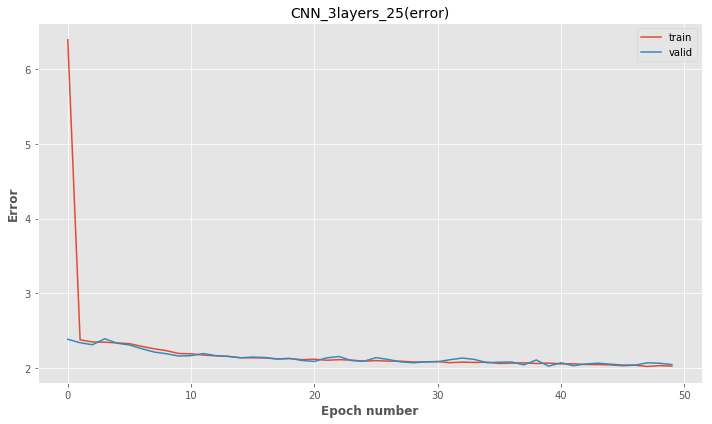

In [8]:
data = np.load('CNN_3layers_25.npy')

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[0].shape[0]), data[0], label = 'train')
ax_1.plot(np.arange(data[2].shape[0]), data[2], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('Error', fontsize = 12, fontweight = 1000)
ax_1.set_title('CNN_3layers_25(error)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('CNN_3layers_25(error).pdf')

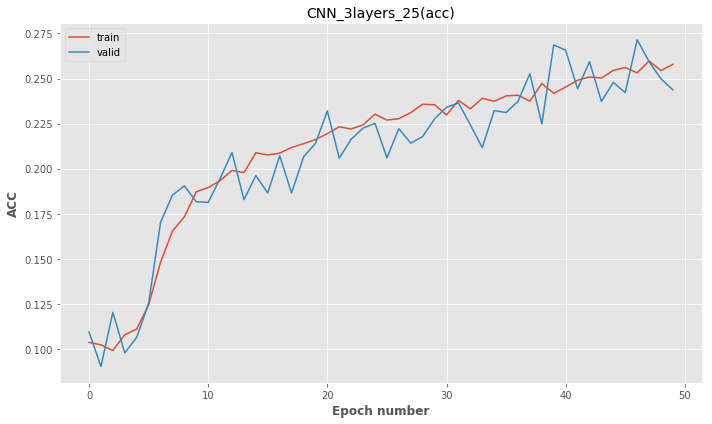

In [9]:
data = np.load('CNN_3layers_25.npy')

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[1].shape[0]), data[1], label = 'train')
ax_1.plot(np.arange(data[3].shape[0]), data[3], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('ACC', fontsize = 12, fontweight = 1000)
ax_1.set_title('CNN_3layers_25(acc)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('CNN_3layers_25(acc).pdf')

In [10]:
weights = {
    'c1': tf.Variable(tf.random_normal([5, 1, 1, 5])),
    'c2': tf.Variable(tf.random_normal([5, 1, 5, 10])),
    'c3': tf.Variable(tf.random_normal([5, 1, 10, 10])),
    'd1': tf.Variable(tf.random_normal([7*25*10,350])),
    'd2': tf.Variable(tf.random_normal([350,100])),
    'out': tf.Variable(tf.random_normal([100,25]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([5])),
    'b2': tf.Variable(tf.random_normal([10])),
    'b3': tf.Variable(tf.random_normal([10])),
    'd1': tf.Variable(tf.random_normal([350])),
    'd2': tf.Variable(tf.random_normal([100])),
    'out': tf.Variable(tf.random_normal([25]))
}

def multilayer_cnn(data):
    conv1 = tf.nn.tanh(conv2d(data, weights['c1']) + biases['b1'])
    pool1 = pool(conv1, 2, 1)
    conv2 = tf.nn.tanh(conv2d(pool1, weights['c2']) + biases['b2'])
    pool2 = pool(conv2, 3, 1)
    conv3 = tf.nn.tanh(conv2d(pool2, weights['c3']) + biases['b3'])
    pool3 = pool(conv3, 2, 1)
    pool3_flat = tf.reshape(pool3, [-1, 7*25*10])
    d1_layer = tf.nn.tanh(tf.matmul(pool3_flat, weights['d1']) + biases['d1'])
    d2_layer = tf.nn.tanh(tf.matmul(d1_layer, weights['d2']) + biases['d2'])
    out_layer = tf.matmul(d2_layer, weights['out']) + biases['out']
    return out_layer
out_layer = multilayer_cnn(inputs)

per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=targets)
error = tf.reduce_mean(per_datapoint_errors)
#regularizer = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2'])+tf.nn.l2_loss(weights['out'])
#error = tf.reduce_mean(error + beta * regularizer)

per_datapoint_pred_is_correct = tf.equal(tf.argmax(out_layer, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()
sess.run(init_op)
import data_providers_cnn as data_providers_cnn
train_data = data_providers_cnn.MSD25GenreDataProvider('train', batch_size=50, flatten=True, one_hot=True)
valid_data = data_providers_cnn.MSD25GenreDataProvider('valid', batch_size=50, flatten=True, one_hot=True)

num_epoch = 50
error_train = []
error_valid = []
acc_train = []
acc_valid = []

for e in range(num_epoch):
    running_error = 0.
    running_acc = 0.
    for input_batch, target_batch in train_data:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], 
            feed_dict={inputs: input_batch, targets: target_batch})
        running_error += batch_error
        running_acc += batch_acc
    running_error /= train_data.num_batches
    running_acc /= train_data.num_batches
    print('End of epoch {0}: running error average = {1:.2f}'.format(e + 1, running_error), 
          'running acc average = {1:.2f}'.format(e + 1, running_acc))
    error_train = np.append(error_train, running_error)
    acc_train = np.append(acc_train, running_acc)
    a = get_error_and_accuracy(valid_data)
    error_valid = np.append(error_valid, a[0])
    acc_valid = np.append(acc_valid, a[1])
    
CNN_3cnn_2d_25 = [error_train, acc_train, error_valid, acc_valid]
np.save('CNN_3cnn_2d_25', CNN_3cnn_2d_25)

End of epoch 1: running error average = 8.21 running acc average = 0.13
End of epoch 2: running error average = 2.47 running acc average = 0.12
End of epoch 3: running error average = 2.31 running acc average = 0.13
End of epoch 4: running error average = 2.27 running acc average = 0.15
End of epoch 5: running error average = 2.22 running acc average = 0.16
End of epoch 6: running error average = 2.21 running acc average = 0.16
End of epoch 7: running error average = 2.19 running acc average = 0.17
End of epoch 8: running error average = 2.17 running acc average = 0.17
End of epoch 9: running error average = 2.18 running acc average = 0.17
End of epoch 10: running error average = 2.16 running acc average = 0.18
End of epoch 11: running error average = 2.15 running acc average = 0.18
End of epoch 12: running error average = 2.14 running acc average = 0.18
End of epoch 13: running error average = 2.13 running acc average = 0.18
End of epoch 14: running error average = 2.12 running acc av

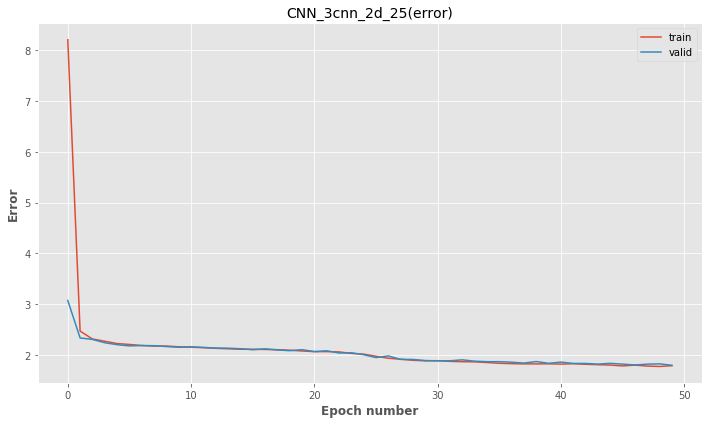

In [11]:
data = np.load('CNN_3cnn_2d_25.npy')

fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[0].shape[0]), data[0], label = 'train')
ax_1.plot(np.arange(data[2].shape[0]), data[2], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('Error', fontsize = 12, fontweight = 1000)
ax_1.set_title('CNN_3cnn_2d_25(error)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('CNN_3cnn_2d_25(error).pdf')

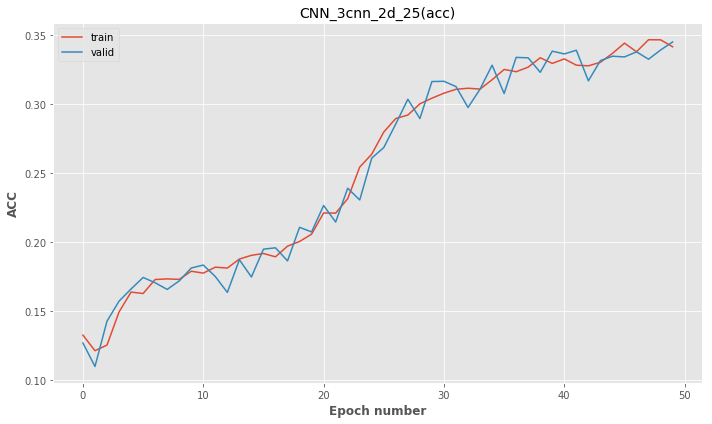

In [12]:
data = np.load('CNN_3cnn_2d_25.npy')
fig_1 = plt.figure(figsize=(10,6))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(np.arange(data[1].shape[0]), data[1], label = 'train')
ax_1.plot(np.arange(data[3].shape[0]), data[3], label = 'valid')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number',fontsize = 12, fontweight = 1000)
ax_1.set_ylabel('ACC', fontsize = 12, fontweight = 1000)
ax_1.set_title('CNN_3cnn_2d_25(acc)', fontsize = 14)
plt.tight_layout()
fig_1.savefig('CNN_3cnn_2d_25(acc).pdf')